# (Old) Hypothesis Testing

In this project we'll be exploring basic hypothesis testing. What is a hypothesis test? It's a way to check the likliehood of a proposed statistical outcome. What follows are some examples of hypothesis tests and the way we can characterise the evidence we have to support some statistical conjecture. So let's get started!

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as pl
from scipy.stats import t, norm

## An Example

I grabbed some numbers to provide an example from [here](https://onlinecourses.science.psu.edu/statprogram/node/139). Please read the example (it's the first one at the top of the page). We'll take the numbers and use them to provide a concrete set of calculations.

In [2]:
cutstring = """
170	167	174	179	179
156	163	156	187	156
183	179	174	179	170
156	187	179	183	174
187	167	159	170	179
"""
nums = np.array([float(x) for x in cutstring.split()]) # a trick to pull the numbers from a string
nums

array([170., 167., 174., 179., 179., 156., 163., 156., 187., 156., 183.,
       179., 174., 179., 170., 156., 187., 179., 183., 174., 187., 167.,
       159., 170., 179.])

The linked example uses a software package called "MiniTab" to do statistical calculations, but "We don't need no stinkin' MiniTab", we've got python! ;-) (Apologies to Mel Brooks). We can use array operations and plain ol' math to do most of what we need and the built-in libararies in numpy and scipy for the rest. First let's reproduce the basic statistics from the example.

Note that there are two ways to compute the standard deviation. The first is "manual" using the sum and sqrt method, the second uses the [built-in `std` method of numpy](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.std.html). Note also the use of the `ddog` (delta degrees of freedom) argument to `std` that sets the small sample size correction to the formula.

In [3]:
print("Sample mean, manual:", nums.sum()/len(nums))
print("Sample mean, built-in:", nums.mean())
print("Sample Standard Dev., manual:", np.sqrt(((nums - nums.mean())**2).sum()/(len(nums)-1)))
print("Sample Standard dev., built-in:", nums.std(ddof=1))
stderr = nums.std(ddof=1)/np.sqrt(len(nums))
print("Standard error:", stderr)
tscore = (nums.mean()-170.0)/stderr
print("t-score, manual:", tscore)

Sample mean, manual: 172.52
Sample mean, built-in: 172.52
Sample Standard Dev., manual: 10.312290401910397
Sample Standard dev., built-in: 10.312290401910397
Standard error: 2.0624580803820796
t-score, manual: 1.2218430153659992


So the way the example reads it seems the situation is this: The engineer measured the hardness of 25 samples of iron. He gets a sample mean of 172.52 and a sample standard deviation of 10.312. He suspects that the mean hardness of the population is greater than 170, but wants to show this statistically. The standard method of hypothesis testing is to assume your hunch is wrong. Assume that the mean is really 170 and that what you're witnessing is a statistical fluctuation. The hypothesis that you're seeing a fluctuation is the "null hypothesis". You want to estimate the chance that the data you're seeing is consistent with the null hypothesis. If that probability is *low* you can reject the null hypothesis and accept the alternative (your hunch). Otherwise you accept the null hypothesis and reject the hunch. Let's see how this plays out in the example.

In the linked example the engineer asks MiniTab to do a 't-test', which is a fancy way to compute the probability that his sample of 25 would have a sample mean equal to 172.52 or greater. This requires using the 't-distribution' cdf and evaluating that probability. (more about this later). However we can just do the simulation directly!

In [4]:
M=10000    # run this monte-carlo experiment with M trials
N=25       # each trial is a sample of 25 values
count=0    # how many have a mean greater than 172.5?

for i in range(M):
    r=np.random.normal(scale=10.31,loc=170.0,size=N)  # pull a sample
    if r.mean()>=172.52:                              # check the sample mean
        count += 1
        
print("Monte-carlo result:", count/M)
print("Theoretical: ", 1.0-norm.cdf(1.221843))

Monte-carlo result: 0.1059
Theoretical:  0.110883502036


So about 11% of the sample means are greater than 172.5 by chance alone [see note 1 for extra details]. This probability is called the 'p-value'.

In the cell that follows we'll investiage the behavior of the sample mean and the sample standard deviation (square root of the average square deviation from the mean). We'll see that the "obvious" way to calculate this is biased, and we'll learn some alternative methods.

In [5]:
mu=170.0
std=10.3
N=5
M=10000

smeans = []
sStdNs = []
sStdNm1s = []
sStdNm2s = []
sStdZs = []
sStdTs = []

for i in range(M):
    sample=np.random.normal(loc=mu, scale=std, size=N)
    
    #
    # check various ways to estimate the sample standard deviation:
    #

    sample_mean = sample.sum()/N
    stdN = np.sqrt(((sample-sample_mean)**2).sum()/N)          # root mean square (RMS) deviation
    stdNm1 = np.sqrt(((sample-sample_mean)**2).sum()/(N-1.5))  # corrected RMS deviation
    stdNm2 = np.std(sample, ddof=1.5)                          # same but using built-in function

    #
    # collect the results in a series of lists.
    #

    smeans.append(sample_mean)     # collect samples of all these
    sStdNs.append(stdN)
    sStdNm1s.append(stdNm1)
    sStdNm2s.append(stdNm2)
    
    #
    # Compute and store the 'z' score for the sample mean using fixed std and unbiased sample std
    #
    
    sStdZ = (sample_mean-mu)/(std/np.sqrt(N))          # compute 'z-score'
    sStdT = (sample_mean-mu)/(stdNm1/np.sqrt(N))       # compute 't-score'
    
    sStdZs.append(sStdZ)                               # collect samples of all these
    sStdTs.append(sStdT)
    
print("Sample Mean of means:", np.mean(smeans))
print("Biased estimator:", np.mean(sStdNs))
print("Correction 1, manual:", np.mean(sStdNm1s))
print("Correction 1, built-in:", np.mean(sStdNm2s))


Sample Mean of means: 169.990245208
Biased estimator: 8.68268556625
Correction 1, manual: 10.3777941946
Correction 1, built-in: 10.3777941946


# Compare sample means and std deviations with theory

Let's look a the recorded sample means and standard deviations and compare then with the expected results based on the theory that the sample mean should be normally distributed with a reduced deviation (by $\sqrt{N}$).

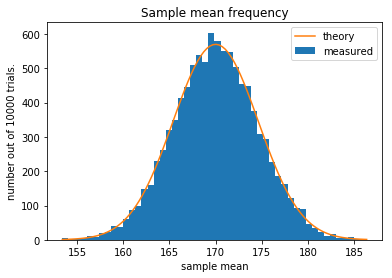

In [6]:
ns,bins,patches = pl.hist(smeans, label="measured",bins=50)
mvals = (bins[:-1]+bins[1:])/2
binwidth = mvals[1]-mvals[0]
expected_stderr = std/np.sqrt(N)
tvals = np.linspace(bins[0],bins[-1],100)
normvals = norm.pdf(tvals, loc=mu, scale=expected_stderr)*M*binwidth
pl.plot(tvals,normvals, label="theory")
pl.title("Sample mean frequency")
pl.xlabel("sample mean")
pl.ylabel("number out of %i trials." % M)
pl.legend()

Gorgeous! How about the simple standard deviation formula?

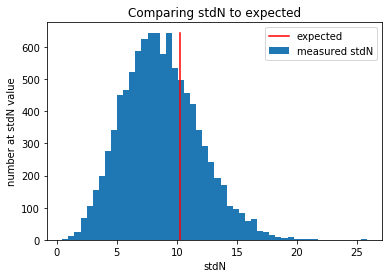

In [7]:
ns,bins,patches = pl.hist(sStdNs, bins=50, label="measured stdN")
pl.plot((std,std),(0,max(ns)),'r-', label="expected")
pl.title("Comparing stdN to expected")
pl.xlabel("stdN")
pl.ylabel("number at stdN value")
pl.legend()

Huh? That didn't work. Note that the peak is well left of the standard deviation of the original distribution. This estimator, though it "works" in the limit of *large* sample size, is *biased* for small sample sizes. It will always give us an artificilly small estimate of the standard deviation of a sample of the population. 

We can correct the bias by adjusting the formula. In textbooks a correction of $N-1$ is often used (since it can be proved to remove the bias in the sample variance, it is not unbiased WRT the standard deviation). I'm going to use $N-1.5$ since in my experience it [produces a better result.](https://en.wikipedia.org/wiki/Unbiased_estimation_of_standard_deviation). Note that this is a small effect in any case so either $N-1$ or $N-1.5$ is really OK for most estimates.

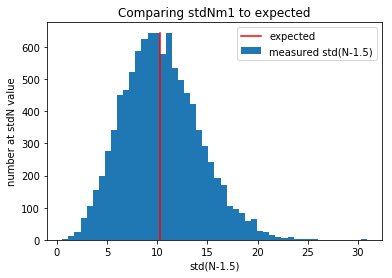

In [8]:
ns,bins,patches = pl.hist(sStdNm1s, bins=50, label="measured std(N-1.5)")
pl.plot((std,std),(0,max(ns)),'r-', label="expected")
pl.title("Comparing stdNm1 to expected")
pl.xlabel("std(N-1.5)")
pl.ylabel("number at stdN value")
pl.legend()

# Standard Z scores for the sample mean

If you want to know how many standard deviations is a particular sample_mean from the populaton mean, how would you compute it?

How about:

$$z = \frac{x - \mu}{\sigma/\sqrt{N}}$$

Where $x$ is the sample, $\mu$ is the population mean, $\sigma$ is the population standard deviation and $N$ is the number of samples taken (from the population) to compute the sample mean. This is a beautiful normal distribution as you would expect. (See how the `sStdZs` list is constructed earlier in this notebook.)

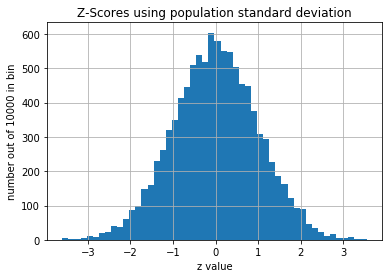

In [9]:
ns,nbins,patches = pl.hist(sStdZs, bins=50, label="measured stdZ")
pl.title("Z-Scores using population standard deviation")
pl.xlabel("z value")
pl.ylabel("number out of %i in bin" % M)
pl.grid()

However if we're really pulling data from a population whose statistics are *unknown* and we want to compute the z-score of a particular sample, we'll have to make a *best* *guess* at the sample standard deviation and that may affect the distribution of z-scores. In fact it does affect the distribution, so much we call these guys t-scores to keep them in a separate class.

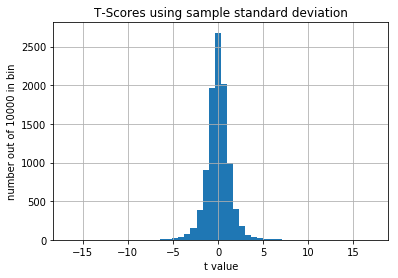

In [10]:
ns,bins,patches = pl.hist(sStdTs, bins=50, label="measured stdT")
pl.title("T-Scores using sample standard deviation")
pl.xlabel("t value")
pl.ylabel("number out of %i in bin" % M)
pl.grid()

Note that the main effect is to shift some samples from the "bell" part of the curve to the "tails". Below is a graph showing the z-score histogram in blue, with the t-score histogram overlaid in yellow.

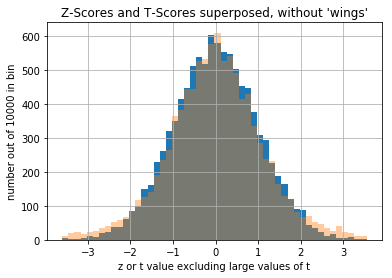

In [11]:
ns,nbins,patches = pl.hist(sStdZs, bins=50, label="measured stdZ")
ns,bins,patches = pl.hist(sStdTs, bins=nbins, label="measured stdT", alpha=0.4)
pl.title("Z-Scores and T-Scores superposed, without 'wings'")
pl.xlabel("z or t value excluding large values of t")
pl.ylabel("number out of %i in bin" % M)
pl.grid()

It's also enlightening to see the normal plot of z-scores, which is pretty straight.

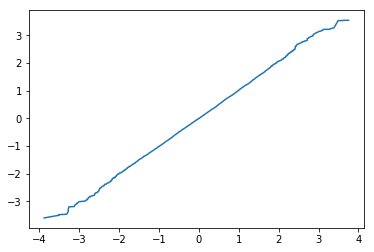

In [12]:
ss=sorted(sStdZs)
ns=sorted(np.random.normal(size=len(ss)))
pl.plot(ns,ss)

And the corresponding normal plot of t-scores, which is not!

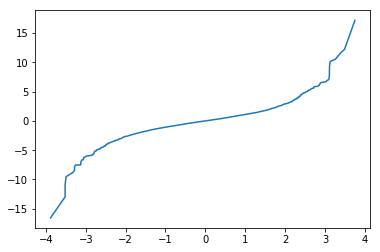

In [13]:
ts=sorted(sStdTs)
pl.plot(ns,ts)

Obviously the t-score distribution is pretty far from normal at this small sample size (N=5). It turns out there is a separate distribution for t-scores, called: The t Distribution. We can use it to estimate the probability distribution of t-scores based on small samples from a population. As the sample size increases, the sample statistics get closer and closer to the population statistics.

# Exercise

Collect data from your communication project. Make a small change to the environment and measure the effect. Use hypothesis testing to show that your effect is either statistically significant, or not. Clearly explain the test you're performing, the null hypothesis, the alternative hypothesis and the p-value of your data. 

In [14]:
M=10000    # run this experiment with M trials
N=25       # each trial is a sample of 25 values
count=0    # how many have a mean greater than 172.5?

for i in range(M):
    r=t.rvs(df=N-1, scale=10.31, loc=170.0,size=N)    # pull a sample
    if r.mean()>=172.52:                              # check the sample mean
        count += 1
        
print("monte-carlo result: ", count/M)
print("theoretical: ", 1.0-t.cdf(1.221843,df=N-1))


monte-carlo result:  0.1162
theoretical:  0.116816401035


Note 1, below, explains another way we could estimate the probability from the first example, but the difference between this result, and our original results is pretty tiny.

1. Technically we could've used the t-distribution here to be more precise, since we're estimating the probability with a sample standard deviation. At this sample size the effect is not significant (0.112 vs. 0.117). You can see the t-distribution version below.